In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from dataclasses import dataclass
from dataclasses import field
from copy import copy
from  matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

import random



matplotlib.rcParams['animation.embed_limit'] = 2**128

def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','scipy','scipy.optimize','dataclass']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IAN VETTER**
I have attempted to create a simplified version of the agent-based predator prey model that invokes reinforcement Q-Learning to bias the populations over time. In the main model, I spawn in one predator (fox) as a singular agent, and non-agent prey (rabbits) placed across a 2x2 grid. The predator's state is represented by its current position and nearby food sources, and it is updated on each step based on a simple linear Q-net. The predator is linearly rewarded based on the number of prey they consume within a period T, with larger rewards provided for specific scenarios, such as keeping the prey population under a certain threshhold by the end of the period. The plots below are based on the predator learning optimal strategies for hunting the prey. In these scenarios, the prey locations are initialized with certain patterns on the grid to mimic population clusters or families in the environment. For example, the prey may be initially biased to one corner or one side of the grid:

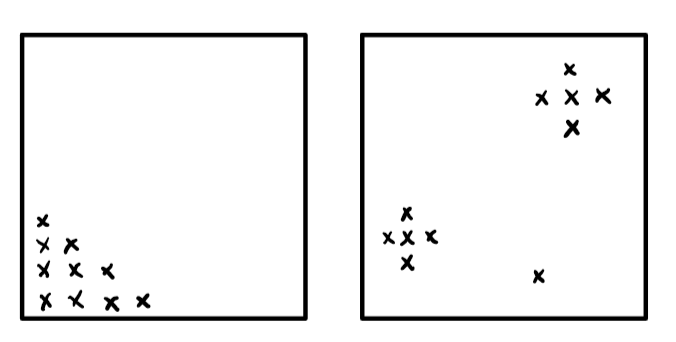




Below is the code that goes into the pred/prey simulation. Most of the functions are reused (but tweaked) from the pred/prey assignment a few weeks back, and additional functions are added to incorporate the Q-learning functionality, i.e. an initialization, simulation reset for training iterations, step function to run the predator's next action, etc. Unfortantely, I haven't been able to figure out how to animate the end result (a fully trained predator in the simulation), so I only have the training performance over time. As I mentioned above, the overall score the predator earns on each iteration is roughly based on how many individual prey it comsumes during the period, so a higher score signifies more efficient, learned hunting patterns. In the future, I hope to return to this project to implement the animation of a trained predator as well as multi-agent functionality.

In [ ]:
class runsim:
  
#bunnies = LocationsToListBunny(self.bunnyLocations)
#foxes = LocationsToListFox(self.foxLocations) 


  def __init__(self, size):

      self.size = size
      self.foxLocations=np.zeros((size, size))
      self.foxLocations[int(size/2)][int(size/2)] = 1
      self.bunnyLocations= np.zeros((size, size))
      for x in range(size):
        for y in range(size):
          r = np.random.uniform() - 0.95
          if (x**2 + y**2 <= 100):
            r += 0.1
          if (r > 0):
            self.bunnyLocations[x][y] = 1
  
      self.bunnies = list(runsim.LocationsToListBunny(self.bunnyLocations, size))
      self.foxes = fox()
      self.foxes.location = self.foxLocations
      self.score=0
      self.t = 0
      self.alpha = 0.0025
      self.R = 0.01
      self.F = 0.01
      self.ff = 0.01 ##################
      self.maxscore = 0
      self.num_ter = 0

  def reset(self):
      # init game state
      size = self.size
      self.foxLocations=np.zeros((self.size, self.size))
      self.foxLocations[int(self.size/2)][int(self.size/2)] = 1
      self.bunnyLocations= np.zeros((size, size))
      for x in range(size):
        for y in range(size):
          r = np.random.uniform() - 0.95
          if (x**2 + y**2 <= 100):
            r += 0.1
          if (r > 0):
            self.bunnyLocations[x][y] = 1
      self.bunnies = runsim.LocationsToListBunny(self.bunnyLocations, self.size)
      self.foxes = fox()
      self.foxes.location = self.foxLocations
      self.size = self.size
      self.score = 0
      self.t = 0
      self.alpha = 0.01
      self.R = 5
      self.F = 0.1
      self.ff = 0.01 
      self.maxscore = 0
      self.num_ter = 0


  def LocationsToListBunny(locations, s):
    bunnies = []
    for locx in range(len(locations)):
      for locy in range(len(locations[locx])):
        if (locations[locx][locy] == 1):
          bunn = bunny()
          bunn.location = np.zeros((s, s))
          bunn.location[locx][locy] = 1
          bunnies.append(bunn)

    return bunnies

  def ReproduceB(bunnies, alpha, s):
    for b in bunnies:
      r = np.random.uniform()
      if (r < alpha):
        bun = bunny()
        bun.location = np.zeros((s, s))
        bun.location[random.randint(0, s-1)][random.randint(0, s-1)] = 1
        bun.eaten = False
        bunnies.append(bun)
    return bunnies

  def LocationsToListFox(locations):
    foxes = []
    for locx in range(len(locations)):
      for locy in range(len(locations[locx])):
        if (locations[locx, locy] == 0):
          continue
        for i in range(int(locations[locx, locy])):
          foxes.append(fox())
          foxes[-1].location = [locx, locy]
          
    return foxes

  def Eat(self):

    #if (np.random.uniform() > 0.5):
    #  self.foxes.full += 1

    bunnies = self.bunnies.copy()
    self.bunnies=[]

    idx=0
    for bunny in bunnies:
      lloc = list(zip(*np.where(bunny.location == 1)))
      lloc2 = list(zip(*np.where(self.foxes.location == 1)))
      if (lloc[0] == lloc2[0]):
          #if (bunny.eaten == False):
            self.foxes.full += 1
            bunny.eaten = True
            bunnies.pop(idx)
      else:
            self.bunnies.append(bunny)
      idx+=1


    
        


  def GetLocationsF(animalList, s):
    locs = np.zeros((s, s))
    for animal in animalList:
      locx, locy = animal.location
      locs[locx, locy] += 1
    return locs


  def GetLocationsB(animalList, s):
    locs = np.zeros((s, s))
    for animal in animalList:
      locx, locy = animal.location
      locs[locx, locy] += 1
    return locs


  def MoveB(self, s):
    creatures = self.bunnies.copy()
    self.bunnies = []
    
    for cre in creatures:

      x_move = np.random.choice([-1, 0, 1])
      y_move = np.random.choice([-1, 0, 1])

      cre.location = np.roll(cre.location, x_move, 0)
      cre.location = np.roll(cre.location, y_move, 1)

      newcre = bunny()
      newcre.location = cre.location
      self.bunnies.append(newcre)

      
  def step(self, action, T):
        self.t += 1
        self._move(action)
        reward = 0
        game_over = False

        if self.t > T:
            game_over = True
            reward = self.foxes.full
            return reward, game_over, self.score

        if  len(self.bunnies) <= 0.055*self.size**2:
            self.score += 50
  
        runsim.Eat(self)
        runsim._move(self, action)
        runsim.MoveB(self, self.size)
        #self.foxes = ReproduceF(self.foxes, self.R, self.F, self.s, self.ff)
        self.bunnies = runsim.ReproduceB(self.bunnies, self.alpha, self.size)
        #self.locsF.append(GetLocationsF(foxes, s))
        #self.locsB.append(GetLocationsB(bunnies, s))
        self.score += 2 * self.foxes.full
        reward = 10
        if (self.foxes.full > self.maxscore):
          self.maxscore = self.foxes.full
          self.score += 50
          reward = 25
           
      
        return reward, game_over, self.score

  def _move(self, action):

        s = self.size

        xm = action[0]
        ym = action[1]

        loc = self.foxes.location
        lloc = list(zip(*np.where(loc == 1)))[0]
        new_loc = np.zeros((s, s))
        xp=lloc[0]
        yp=lloc[1]

        if (xp+xm >= s):
          xm=0
        if (xp-xm < 0):
          xm=0
        if (yp+ym >= s):
          ym=0
        if (yp-ym < 0):
          ym=0

        new_loc[xp+xm][yp+ym] = 1
      
        self.foxes.location = new_loc 
    
        #self.foxes = runsim.LocationsToListFox(self.foxLocations)





In [ ]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
 
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()



Game 1 Score 832 Record: 832
Game 2 Score 1550 Record: 1550
Game 3 Score 898 Record: 1550
Game 4 Score 1852 Record: 1852
Game 5 Score 1508 Record: 1852
Game 6 Score 1138 Record: 1852
Game 7 Score 1972 Record: 1972
Game 8 Score 1420 Record: 1972
Game 9 Score 1360 Record: 1972
Game 10 Score 1190 Record: 1972
Game 11 Score 1046 Record: 1972
Game 12 Score 1226 Record: 1972
Game 13 Score 974 Record: 1972
Game 14 Score 1340 Record: 1972
Game 15 Score 1454 Record: 1972
Game 16 Score 1702 Record: 1972
Game 17 Score 1866 Record: 1972
Game 18 Score 1518 Record: 1972
Game 19 Score 1174 Record: 1972
Game 20 Score 1342 Record: 1972
Game 21 Score 990 Record: 1972
Game 22 Score 1136 Record: 1972
Game 23 Score 1786 Record: 1972
Game 24 Score 3024 Record: 3024
Game 25 Score 1138 Record: 3024
Game 26 Score 1954 Record: 3024
Game 27 Score 1592 Record: 3024
Game 28 Score 920 Record: 3024
Game 29 Score 1592 Record: 3024
Game 30 Score 1520 Record: 3024
Game 31 Score 1910 Record: 3024
Game 32 Score 1464 Reco

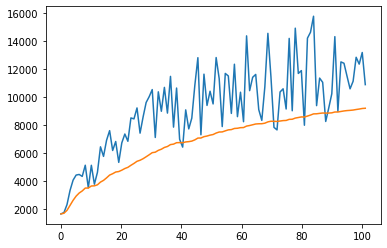

In [ ]:
from pyparsing.helpers import locatedExpr
from collections import deque
import matplotlib.pyplot as plt

### ANSWER ME
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001


@dataclass
class bunny:
    location: list = field(default_factory=list)
    eaten: bool = False   

class fox:
    full: int = 2

    def __init__(self):

        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(8, 256, 9)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)
        self.location = np.zeros((1, 1))

    def get_state(self, game):
       
       currLoc = game.foxes.location
       foodclosexp = False
       foodclosexn = False
       foodcloseyp = False
       foodcloseyn = False
       dabunnies = game.bunnies

       for bunny in dabunnies:
         if (np.array_equal(bunny.location, np.roll(currLoc, -1, axis = 0))):
           foodclosexn= True
         if (np.array_equal(bunny.location, np.roll(currLoc, +1, axis = 0))):
           foodclosexp = True
         if (np.array_equal(bunny.location, np.roll(currLoc, -1, axis = 1))):
           foodcloseyn= True
         if (np.array_equal(bunny.location, np.roll(currLoc, +1, axis = 1))):
           foodcloseyp = True
       
       currx = 0
       curry = 0
       for i in range(len(currLoc)):
         for j in range(len(currLoc[i])):
            if (currLoc[i][j] == 1):
              currx = i
              curry = j

       state = [not foodclosexn, not foodclosexp, not foodcloseyn, not foodcloseyp, currx, curry, game.foxes.full, len(game.bunnies)]

       return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 75 - self.n_games
        final_move = [0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[0] = random.randint(-1, 1)
            final_move[1] = random.randint(-1, 1)
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            if (move == 0):
              final_move[0] = -1
              final_move[1] = 1
            if (move == 1):
              final_move[0] = 0
              final_move[1] = 1

            if (move == 2):
              final_move[0] = 1
              final_move[1] = 1

            if (move == 3):
              final_move[0] = -1
              final_move[1] = 0
            if (move == 4):
              final_move[0] = 0
              final_move[1] = 0
            if (move == 5):
              final_move[0] = 1
              final_move[1] = 0
            if (move == 6):
              final_move[0] = -1
              final_move[1] = -1
            if (move == 7):
              final_move[0] = 0
              final_move[1] = -1
            if (move == 8):
              final_move[0] = 1
              final_move[1] = -1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = fox()
    game = runsim(20)
    mean_score = 1000
    while (agent.n_games <= 100):
        state_old = agent.get_state(game)
        final_move = agent.get_action(state_old)
        reward, done, score = game.step(final_move, 100)
        state_new = agent.get_state(game)
        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)
        

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_scores.append(score)
            plot_mean_scores.append(mean_score)

    return plot_scores, plot_mean_scores



toplot, meanplot = train()
plt.plot(np.linspace(0, 101, 101), toplot)
plt.plot(np.linspace(0, 101, 101), meanplot)

plt.show()






The above plot represents the predator's score (efficiency of hunting prey) with the prey populations initialized in the bottom-left corner of the grid. We can see that the predator quickly learns a strategy to chase the prey into the corner and maximimize its score.